# Introduction

In the following notebook, I will be attempting to predict the insurance cost per individual in the insurance dataset from [Kaggle](https://www.kaggle.com/mirichoi0218/insurance). 

My aim in this notebook is to continue my understanding and practice of different data science techniques for data analysis. In this notebook, I will be performing the following:
- Exploratory Data Analysis using Seaborn and Matplotlib
- Utilizing Decision Tree Regressor, Random Forest Regressor and Gradient Boosted Regressor.
- Model performances will be optimized using Randomized Search
- Model performances will be evaluated using K-Fold Cross Validation

# Things to add
- Adjusted r2, AIC, BIC, updated metrics
- Model evalutation techniques for regression
- Add a Pipe
- feature engineering
- Discussion

In [1]:
#Read in libraries
import pandas as pd
import numpy as np
import pandas_profiling

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import statsmodels.api as sm
import re
import statsmodels.formula.api as smf

#Import warnings filter
from warnings import simplefilter

#Ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

#Set Plot Style for Notebook
sns.set(style="whitegrid")


In [2]:
#Read in data
df = pd.read_csv('insurance.csv')

# Data Overview

**Variables**

age: age of primary beneficiary

sex: insurance contractor gender, female, male

bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

children: Number of children covered by health insurance / Number of dependents

smoker: does beneficiary smoke cigarettes?

region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

charges: Individual medical costs billed by health insurance

**Pandas Profiling Report**

In [3]:
# #Create Pandas Profiling Report
# profile = df.profile_report(title='Pandas Profiling Report')

# #Print Profile Report
# print(profile)

# #Create html file of Profile Report for reference
# profile.to_file(output_file="Health Insurance Pandas Report.html")

**Data Cleaning**

Encode sex and smoker variable with 1's and 0's. One-hot-encode region variable and rename new columns for clarity.

In [4]:
#Drop duplicate rows
df.drop_duplicates(inplace=True)

#Encode male:1, female:0
df['sex']= df['sex'].apply(lambda x: 1 if x =='male' else 0)

#Encode smoker:1, nonsmoker:0
df['smoker']=df['smoker'].apply(lambda x: 1 if x=='yes' else 0)

#Encode Regions w/ Dummy Variables
df = pd.get_dummies(df, columns=['region', 'children'], drop_first=False)

#Assign new column names
new_cols = ['northeast','northwest', 'southeast', 'southwest',
           'No_children', '1_child', '2_children','3_children','4_children', '5_children']

#Rename columns
df.rename(columns=dict(zip(df.columns[5:], new_cols)),inplace=True)

# Exploratory Data Analysis

### Correlation Matrix

Variable Correlation with outcome variable: charges
charges        1.000000
smoker         0.787234
age            0.298308
bmi            0.198401
southeast      0.073578
2_children     0.069333
3_children     0.062558
sex            0.058044
4_children     0.006517
northeast      0.005945
1_child       -0.025598
northwest     -0.038695
5_children    -0.043357
southwest     -0.043637
No_children   -0.063985
Name: charges, dtype: float64

Dataset Heatmap: 



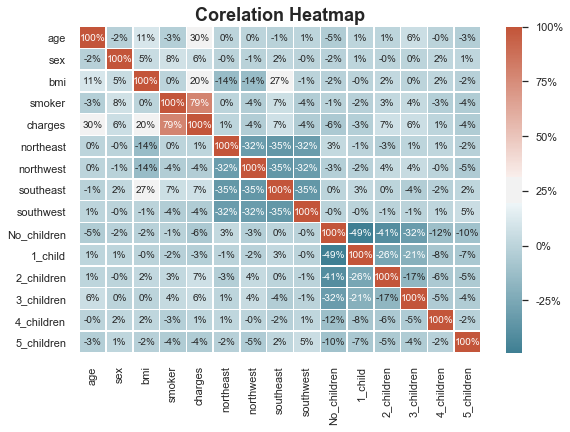

In [5]:
#Correlation matrix of outcome variable charges
corr = df.corr()
print('Variable Correlation with outcome variable: charges')
print(corr['charges'].sort_values(ascending = False))

#Print heatmap of dataframe
print('\nDataset Heatmap: \n')

#Set plot for heatmap
f, ax = plt.subplots(figsize=(9, 6))

#Format color bar
from matplotlib.ticker import FuncFormatter
fmt = lambda x,pos: '{:.0%}'.format(x)

#Set heatmap title
ax.set_title('Corelation Heatmap',fontsize = 18, fontweight = 'bold')

#plot heatmap
sns.heatmap(corr, 
            annot = True,
            linewidths=.5, fmt='.0%',
            cbar_kws={'format': FuncFormatter(fmt)},
            cmap=sns.diverging_palette(220, 20, sep=20, as_cmap=True),
            ax=ax);

Per our heatmap, it appears our charges variable is highly correlated with our smoker variable, followed by age and BMI respectively.

Additional points of interest:
* Out of all of the regions, the southeast has the strongest(albeit a weak) correlation with the charges variable.
* Sex has no correlation with charges.

Let's look into the distribution of charges of smokers vs non-smokers.

### Smoker vs Non-Smoker Charge Distributions

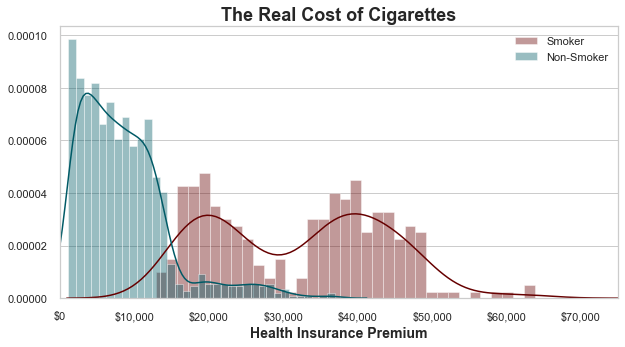

In [6]:
#Create figure
fig, ax = plt.subplots(figsize = (10,5))

#Smoker charge Distribution(Blue)
sns.distplot(df['charges'][df['smoker']==1],bins=35, label='Smoker',
             ax=ax, color = '#660000'); 

#Nonsmoker charge Distribution(Red)
sns.distplot(df['charges'][df['smoker']==0],bins=35,label='Non-Smoker',
             ax=ax, color = '#005A66');

#Set title
ax.set_title('The Real Cost of Cigarettes',fontsize = 18, fontweight = 'bold')

#Set X label
ax.set_xlabel("Health Insurance Premium", fontsize = 14, fontweight = 'bold')

#Set limits x-axis
ax.set_xlim(0,75_000)

#Format charges on x-axis
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick)

#Mute vertical grid lines
ax.xaxis.grid()

#Show legend
ax.legend();

Smokers are paying significantly more in insurance premiums than non-smokers. In our smoker distribution, there appears to be 2 populations centered around \\$20,000 and $40,000. Perhaps this has to do with age or BMI?

Let's investigate.

### BMI and Insurance Premium

Let's take a look at a scatterplot with BMI and charges. We know that smokers have a significantly higher insurance premium than non-smokers, but there appears to be two subgroups within the smoker premium distribution. Perhaps BMI has something to do with it.

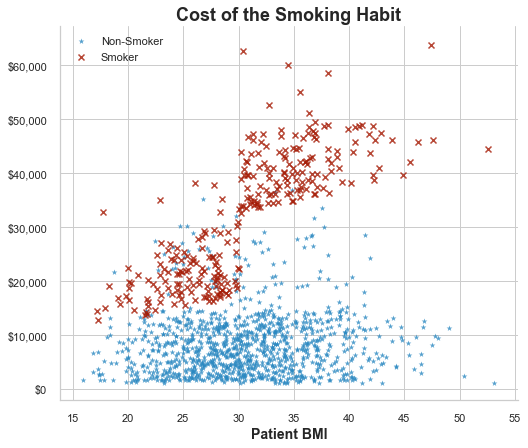

In [7]:
#Set Colors
colors= ['#2A88C1','#A51A04']

#lmplot bmi vs charges w/ smoker hue
sns.lmplot(x = 'bmi', y = 'charges', height=6, aspect=1.25, markers = ['*','x'],
           fit_reg=False, palette=colors, hue = 'smoker', legend=False, 
           data = df);


#Set Title
ax = plt.gca()
ax.set_title('Cost of the Smoking Habit',fontsize = 18, fontweight = 'bold')

#Set x and y labels
ax.set_xlabel("Patient BMI", fontsize = 14, fontweight = 'bold')
ax.set_ylabel('')

#Set new title for legend
legend = ax.legend()
legend.texts[0].set_text("Non-Smoker")
legend.texts[1].set_text("Smoker")

#Set tick label format
ax.yaxis.set_major_formatter(tick) 

Excellent, it appears that the two groups within the smoker premium distribution can be explained by the patient BMI. As patient BMI increases beyond 30, there is a significant jump in the average premium charge. 

Body mass index (BMI) is a measurement of body fat based on height and weight of a person. Weight classes are assigned to adult men and women as illustrated by the following chart:

In [8]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://amp.businessinsider.com/images/57d291cadd0895c6308b46b0-960-742.png", height=600, width =600)

How do smokers and non-smoker's charges compare within each BMI Class?

In [9]:
#Function assigns bmi class based on bmi
def bmi_classification(x):
    if x <18.5:
        return('Underweight')
    elif x <25:
        return('Healthy')
    elif x <30:
        return('Overweight')
    else:
        return('Obese')

#Apply function to df and assign to new column
df['bmi_class']= df['bmi'].apply(bmi_classification)

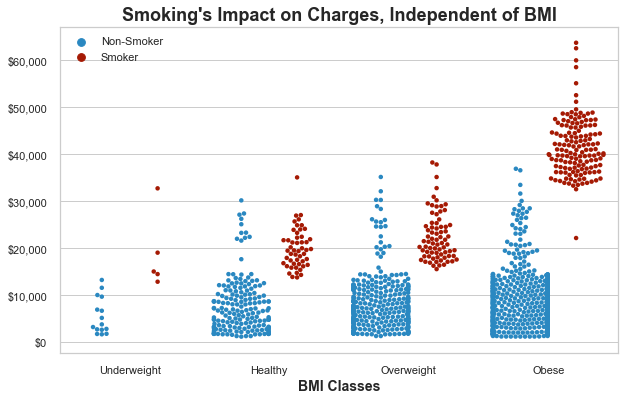

In [10]:
#Set fig-size
fig, ax = plt.subplots(figsize = (10,6))

#Set Colors
colors= ['#2A88C1','#A51A04']

#Set swarmplot bmiclass vs charges w/ smoker hue
g = sns.swarmplot(x='bmi_class', y='charges', data=df, dodge=True,
                   palette= colors, size=4.5,
              order= ["Underweight", "Healthy", "Overweight", "Obese"],
              hue='smoker');

#Set Plot Title
ax.set_title('Smoking\'s Impact on Charges, Independent of BMI',fontsize = 18, fontweight = 'bold')

#Set x and y label
ax.set_xlabel("BMI Classes", fontsize = 14, fontweight = 'bold')
ax.set_ylabel("")

#Set new title for legend
legend = ax.legend()
legend.texts[0].set_text("Non-Smoker")
legend.texts[1].set_text("Smoker")

#Format Charges Axis
ax.yaxis.set_major_formatter(tick)

Amazing, we can see the severe impact smoking has on premium charges. Let's take a look and explore our age variable and see how charges are impacted by age.

# Age and Premiums

Let's start with looking at a joint plot to explore the distribution of charges for smokers and non-smokers by age of the patient.

Text(21.625, 0.5, '')

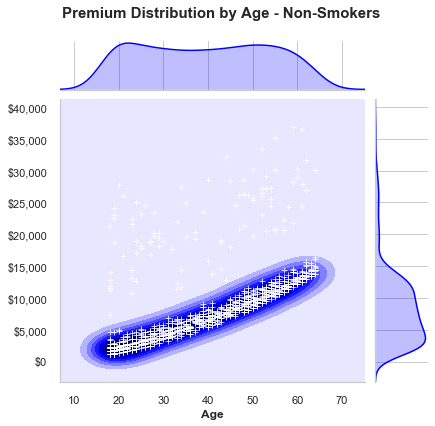

In [11]:
#Age and Charges joint plot for Non-smokers
k= sns.jointplot('age','charges',kind='kde', color='#0000FF', data=df[df['smoker']==0]);
k.plot_joint(plt.scatter, c="white", s=30, linewidth=.75, marker="+");

#Set plot title
ax = plt.gca()
plt.subplots_adjust(top=0.9)
k.fig.suptitle('Premium Distribution by Age - Non-Smokers ', fontsize = 15, fontweight = 'bold')

#Format yaxis ticks
ax.yaxis.set_major_formatter(tick) 

#Set x and y labels
ax.set_xlabel("Age", fontsize = 12, fontweight = 'bold')
ax.set_ylabel("")

Text(21.625, 0.5, '')

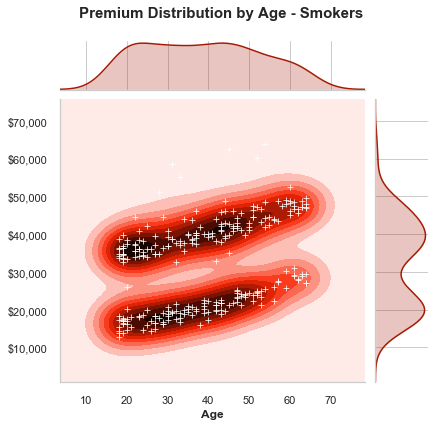

In [12]:
#Age and Charges joint plot for smokers
g= sns.jointplot('age','charges',kind='kde', color='#A51A04', data=df[df['smoker']==1]);
g.plot_joint(plt.scatter, c="white", s=30, linewidth=.75, marker="+");

#Set plot title
ax = plt.gca()
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Premium Distribution by Age - Smokers ', fontsize = 15, fontweight = 'bold')

#Format y tick label
ax.yaxis.set_major_formatter(tick)

ax.set_xlabel("Age", fontsize = 12, fontweight = 'bold')
ax.set_ylabel("")

Looking at the age distributions, we do see a slight linear relationship with charges and age(as age increases, so does the premium). We do see a pretty clear impact of smoking on the total premium, and interestingly enough it looks like those 2 populations we see in the smoker's distribution is due to BMI.

Let's visualize BMI and Age in a 3d space to see if we can find some relationship of interest.

# BMI, Age, and Charges

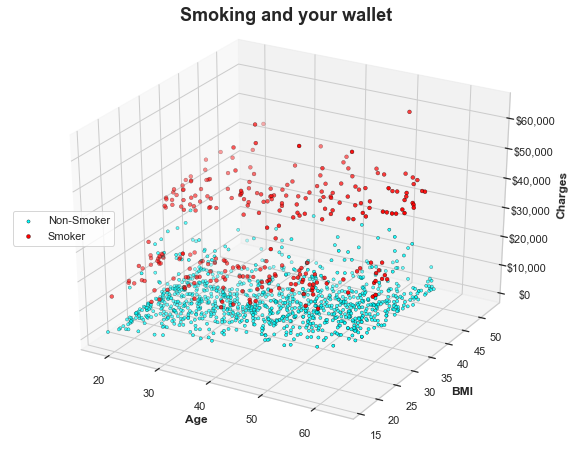

In [13]:
#Import 3D 
from mpl_toolkits.mplot3d import Axes3D

#Create figure
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# Plot 3D scatter plot for Non-Smokers
ax.scatter(df['age'][df['smoker']==0], df['bmi'][df['smoker']==0], 
           df['charges'][df['smoker']==0], c='cyan',edgecolors = 'black',linewidth = .35, s=10, label = 'Non-Smoker')

# Plot 3D scatter plot for Smokers
ax.scatter(df['age'][df['smoker']==1], df['bmi'][df['smoker']==1], df['charges'][df['smoker']==1], 
           c='red', s=15,edgecolors = 'black', linewidth = .35, label = 'Smoker')



#Set Title
ax.set_title('Smoking and your wallet', pad = 25,fontsize = 18, fontweight = 'bold')

#Set Axis Labels
ax.set_xlabel("Age", fontsize = 12, labelpad = 7, fontweight = 'bold')
ax.set_ylabel("BMI", fontsize = 12, labelpad = 10, fontweight = 'bold')
ax.set_zlabel("Charges", fontsize = 12, labelpad = 15, fontweight = 'bold')

#Format z tick label and add spacing
ax.zaxis.set_major_formatter(tick)
ax.tick_params(axis='z', which='major', pad=8)

#Set new title for legend
ax.legend(loc = 6, frameon=True)


plt.show()

The smoking variable by far is the most correlated with charges, as illustrated by the clear seperation for higher cost across both age and BMI. Interestingly enough, we do see more of the extreme cases as BMI increases, but not so much with age. 

Let's do a little exploration looking into how BMI varies across the United States before we move onto machine learning.

# BMI by Regions across the United States

In [14]:
#Convert region dummies back to cat and assign to df
dummies = df.loc[: ,'northeast': 'southwest']
df['region'] = dummies.idxmax(axis=1).str.capitalize()

Text(0, 0.5, 'BMI')

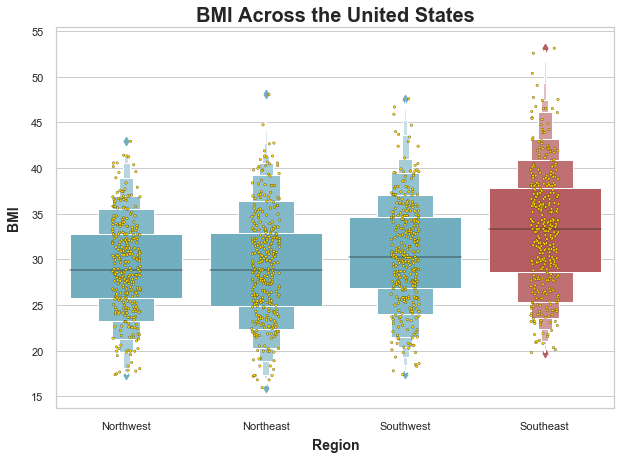

In [15]:
#Set Plot size
fig, ax = plt.subplots(figsize=(10,7))

#Set Colors
my_pal = {region: "r" if region == "Southeast" else "c" for region in df.region.unique()}


#boxenplot bmi by region
g= sns.boxenplot(y = 'bmi', x='region', 
              order= ['Northwest', 'Northeast', 'Southwest', 'Southeast'],
                palette= my_pal,
              data = df, ax=ax);

#Swarmplot bmi by region
k = sns.stripplot(y = 'bmi', x='region', data=df, 
                   edgecolor='black',linewidth=.25,
                   order= ['Northwest', 'Northeast', 'Southwest', 'Southeast'],
                    size=2.5, jitter=True, color="gold", ax=ax)

#Set Title
ax.set_title('BMI Across the United States',fontsize = 20, fontweight = 'bold')

#Set Axis Labels
ax.set_xlabel("Region", fontsize = 14, labelpad = 7, fontweight = 'bold')
ax.set_ylabel("BMI", fontsize = 14, labelpad = 10, fontweight = 'bold')


The region most associated with having a higher BMI is the Southeast, having an almost 5 unit median than the Northwest. We do know that region was not correlated with charges, further supporting the notion that cigarettes are incredibly toxic for your health.

# Data Preparation for Machine Learning

From out exploratory Data Analysis, I think it will be best to fit tree models onto our data to predict the outcome. We were not able to find a linear relationship between our predictors and our target.

We will do some minor data preparation and begin with using a decision tree as our base model. Ideally we will be able to improve upon its performance by using a random forest model and achieve further improvement using a Gradient Boosted model.

**Drop unnecessary columns**

In [16]:
# #Drop bmi_class and region
# df.drop(columns=['bmi_class', 'region'], inplace=True)

**Split data and check shape**

Confirm data is in proper shape to apply cross-validation(CV).

In [17]:
# #Assign data to X and y
# X= df.drop('charges', axis=1).to_numpy()
# y= df['charges'].to_numpy()


# #Print data shapes
# print('X data shape: ', X.shape)
# print('y data shape: ', y.shape, '\n')

**Base Model: Decision Tree**

In [18]:
# #Import decision tree
# from sklearn.tree import DecisionTreeRegressor

# #Import CV
# from sklearn.model_selection import cross_val_score

# #Instantiate Tree(no pre-pruning)
# tree = DecisionTreeRegressor(random_state=0)

# #Instantiate and fit CV to tree and data
# scores = cross_val_score(tree, X, y, cv= 5)

# #Print Cross Validation Score
# print("Cross Validation Scores: {}".format(scores))
# print('Average Cross Validation Score: {:.3f}'.format(np.mean(scores)))

**View Decision Tree Feature Importance**

In [19]:
# #Fit tree
# tree.fit(X,y)

# #Create a function to plot the feature importance of the model
# feature_names = list(df.columns.values)

# #Create feature importance plot
# def plot_feature_importances(model):
#     n_features = X.shape[1]
#     plt.barh(np.arange(n_features), model.feature_importances_, align='center')
#     plt.yticks(np.arange(n_features), feature_names)
#     plt.title("Feature Importance", fontsize = 15 , fontweight='bold')
#     plt.ylabel("")
#     plt.ylim(-1, n_features)
#     plt.grid(b=False, axis='y')

# #Plot feature importance for tree model
# plot_feature_importances(tree)

**Apply Pre-pruning to Decision Tree**

We will tune our model using random search

In [20]:
# #View parameters used by decision tree
# print('Parameters currently in use for decision tree:\n')
# print(tree.get_params())

In [21]:
# #Import random search cross-validation
# from sklearn.model_selection import RandomizedSearchCV

# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']

# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(1, 50, num = 10)]
# max_depth.append(None)

# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]

# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]

# # Create the random grid
# random_grid = {'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf}

# print(random_grid)

In [22]:
# #Use random_grid to search for best hyper parameters
# tree_random = RandomizedSearchCV(estimator=tree, param_distributions= random_grid,
#                                  random_state=0,
#                                n_iter=50, cv = 3, n_jobs=-1)

# #fit Random search model to data
# tree_random.fit(X,y)

# #print best parameters for Decision Tree
# tree_random.best_params_

Tune base model with parameters found through random search. We will utilize an additional grid search with our other models, this is merely to serve as a guide for the decision trees we will need to build later.

In [23]:
# #Instantiate Tree(w/ pre-pruning)
# tuned_tree = DecisionTreeRegressor(random_state=0,
#                              min_samples_split = 10,
#                              min_samples_leaf = 4,
#                              max_features= 'auto',
#                              max_depth = 6) 

# #Instantiate and fit CV to tree and data
# scores = cross_val_score(tuned_tree, X, y, cv= 5)

# #Print Cross Validation Score
# print("Cross Validation Scores: {}".format(scores))
# print('Average Cross Validation Score: {:.3f}'.format(np.mean(scores)))

**View Decision Tree Feature Importance**

In [24]:
# #Fit tuned tree
# tuned_tree.fit(X,y)

# #Plot feature importance for tree model
# plot_feature_importances(tree)

Our tuned Decision Tree did really well, 83.9% is not to be taken lightly. Let's see how well a random forest model will perform on this data.

**Random Forest**

We'll start with a base model random forest.

In [25]:
# #Summon the Random Forest Algorithm
# from sklearn.ensemble import RandomForestRegressor

# #Instantiate the model
# rf = RandomForestRegressor(random_state=0)

# #Instantiate and fit CV to tree and data
# scores = cross_val_score(rf, X, y, cv= 5)

# #Print Cross Validation Score
# print("Cross Validation Scores: {}".format(scores))
# print('Average Cross Validation Score: {:.3f}'.format(np.mean(scores)))

**View Decision Tree Feature Importance**

In [26]:
# #Fit base random forest
# rf.fit(X,y)

# #Plot feature importance for tree model
# plot_feature_importances(tree)

**Find Optimal Random Forest hyperparameters**

We'll tune our base model using random search again, keeping in mind the values for the optimum decision tree we just found.

In [27]:
# #Parameters used by random forest
# print('Parameters currently in use for random forest:')
# print(rf.get_params())

In [28]:
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 4000, num = 10)]

# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']

# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
# max_depth.append(None)

# # Minimum number of samples required to split a node
# min_samples_split = [8, 10, 12]

# # Minimum number of samples required at each leaf node
# min_samples_leaf = [2, 4, 6]

# # Method of selecting samples for training each tree
# bootstrap = [True, False]

# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# print(random_grid)

In [29]:
# #Fit random search with parameters of random forest
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
#                                n_iter = 100, cv = 3, verbose=2, 
#                                random_state=0, n_jobs = -1)

# #Fit the random search model
# rf_random.fit(X, y)

# #Print the best parameters found by random search
# rf_random.best_params_

**Tune Base Random Forest Model**

We'll tune our random forest model using the parameters found by the random search

In [30]:
# #Instantiate the model w/ optimum hyperparameters
# tuned_rf = RandomForestRegressor(random_state=0, n_estimators= 3000,
#                            min_samples_split= 10, min_samples_leaf= 6,
#                            max_features = 'auto', max_depth = 5, bootstrap = True)

# #Instantiate and fit CV to tree and data
# scores = cross_val_score(tuned_rf, X, y, cv= 10)

# #Print Cross Validation Score
# print("Cross Validation Scores: {}".format(scores))
# print('Average Cross Validation Score: {:.3f}'.format(np.mean(scores)))

**View Decision Tree Feature Importance**

In [31]:
# #Fit tuned tree to data
# tuned_rf.fit(X,y)

# #Plot feature importance
# plot_feature_importances(tuned_rf)

**Gradient Boosted Forest**

86% from a tuned random forest is pretty good, let's see how well we can do with a gradient boosted regressor. We'll start again with a base model.

In [32]:
# #Summon Gradient Boosting Regressor
# from sklearn.ensemble import GradientBoostingRegressor

# #Instantiate model
# gbr = GradientBoostingRegressor(random_state=0)

# #Instantiate and fit CV to tree and data
# scores = cross_val_score(gbr, X, y, cv= 10)

# #Print Cross Validation Score
# print("Cross Validation Scores: {}".format(scores))
# print('Average Cross Validation Score: {:.3f}'.format(np.mean(scores)))

**View Decision Tree Feature Importance**

In [33]:
# #Fit tuned tree to data
# gbr.fit(X,y)

# #Plot feature importance
# plot_feature_importances(gbr)

**Find Optimum Hyperparameters using Random Search**

In [34]:
# #Parameters used by random forest
# print('Parameters currently in use for Gradient Boosted Regressor:')
# print(gbr.get_params)

In [35]:
# #learning rate for gradient boosted model
# learning_rate = [0.0001, 0.001, 0.01, 0.1]

# #Loss Function
# loss=['ls', 'lad', 'huber', 'quantile']

# #Number of trees in gradient boosted model
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 4000, num = 10)]

# #Number of features to consider at every split
# max_features = ['auto', 'sqrt']

# #Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
# max_depth.append(None)

# #Minimum number of samples required to split a node
# min_samples_split = [8, 10, 12]

# #Minimum number of samples required at each leaf node
# min_samples_leaf = [2, 4, 6]


# #Create the random grid
# random_grid = {'learning_rate': learning_rate,
#                'loss':loss,
#                'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf}

# print(random_grid)

In [36]:
# #Fit random search with parameters of random forest
# gbr_random = RandomizedSearchCV(estimator = gbr, 
#                                param_distributions = random_grid, 
#                                n_iter = 100, cv = 3, verbose=2, random_state=0, n_jobs = -1)

# #Fit the random search model
# gbr_random.fit(X, y)

# #Print best parameters
# gbr_random.best_params_

**Tune GBR**

In [37]:
# #Summon model with tuned paramters
# tuned_gbr = GradientBoostingRegressor(random_state=0, n_estimators= 2733,
#                                  min_samples_split = 12, min_samples_leaf = 2,
#                                  max_features = 'auto',max_depth = 2,
#                                  loss = 'huber', learning_rate = 0.01)

# #Instantiate model
# scores = cross_val_score(tuned_gbr, X, y, cv= 5)

# #Print Cross Validation Score
# print("Cross Validation Scores: {}".format(scores))
# print('Average Cross Validation Score: {:.3f}'.format(np.mean(scores)))

**View Decision Tree Feature Importance**

In [38]:
# #Fit tuned model to data
# tuned_gbr.fit(X,y)

# #View Feature importances
# plot_feature_importances(gbr)

**Conclusions**

The random forest regressor performed best with an accuracy of 86%. All of our feature importance plots revealed that the most valuable feature was the smoking variable (as we already saw from the EDA)

Some pieces of information that could have been of great benefit to this data set would have been the cause of hospitalization. There were some outliers for young people with really high premiums which may not be caused by smoking but some other confounding variable, such as alcohol or drug use. 
Another interesting piece if information that would have been helpful would be the length of hospitalization. Generally speaking, hospital stay would probably linearly correlate with charges since hospitals are charging for medicines used daily as well as the room used by the patient. 